# Тестовое задание для VK

Для данного задания предлагается использовать полный датасет [MovieLens](https://grouplens.org/datasets/movielens/latest/).

Необходимо построить векторные представления (эмбеддинги) пользователей и
фильмов используя нейросетевые подходы, чтобы можно было по эмбеддингу
пользователя искать похожие эмбеддинги фильмов и рекомендовать ему их.
При выполнении задания обратите внимание на:
1. Разбиение данных на обучение и валидацию, обоснование
2. Выбор и обоснование метрики
3. Разработка архитектуры нейронной сети с пояснениями
4. Обучение и валидация
5. Решение должно быть воспроизводимым, в формате Jupyter Notebook (Google Colab
/ файл на Github) с подробными пояснениями на каждом шаге

## Обработка данных

### Импортируем необходимые библиотки для работы с данными 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
warnings.filterwarnings('ignore')

### Скачиваем и считываем данные в таблицы pandas.

In [ ]:
!gdown 1T01W_PI1ijJGuWIIAGFdpkh9IYF8Xbso
!gdown 1gqbp5LXuIyZHdHcY8SQVdO6AfqTRY9vt

In [ ]:
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

### Посмотрим объём имеющихся данных

In [ ]:
print(f"ratings shape is {ratings.shape}")
print(f"movies shape is {movies.shape}")

ratings shape is (27753444, 4)
movies shape is (58098, 3)


### Удалим ненужную информацию о времени оценки 

In [ ]:
ratings.drop(columns=["timestamp"], inplace=True)
ratings.head(3)

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5


### Определим все имеющиеся жанры
Фильмы с (no genres listed) не будем относить ни к одному жанру. Другой подход был удалить такие объекты из выборки, но я решил так не поступать, т.к. таких фильмов относительно много, и они оценены. 

In [ ]:
genres_list = [genre.split('|') for genre in movies.genres]
unique_genres = np.unique(np.concatenate(genres_list))
unique_genres = unique_genres[unique_genres != "(no genres listed)"]

unique_genres

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype='<U18')

### Используем One-Hot-Encoding на жанры фильмов
Реализовал вручную, т.к. с (no genres listed) неудобно использовать встроенный, например, в Scikit-Learn. 

In [ ]:
movie_genres_dict = {}
for movie in movies.values:
    genre_encodings = {genre : 0 for genre in unique_genres}
    number, title, genres = movie
    genres_list = [genre for genre in genres.split('|')]
    for genre in genres_list:
        if genre == "(no genres listed)":
            break

        genre_encodings[genre] += 1

    movie_genres_dict[number] = genre_encodings

### Считаем общее количество оценок каждого фильма и объединяем полученное в таблицу 

In [ ]:
movie_genres = pd.DataFrame(movie_genres_dict).T
movie_genres.reset_index(inplace=True, names=["movieId"])

num_ratings = ratings.groupby(["movieId"]).rating.count().astype(int)
num_ratings.rename("num_ratings", inplace=True)
movie_genres = movie_genres.merge(num_ratings, how='left', left_on='movieId', right_index=True)

movie_genres.head(3)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_ratings
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,68469.0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,27143.0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,15585.0


### Создаём общую таблицу с userId и оценками

In [ ]:
movie_rating_genres = pd.merge(movie_genres, ratings, how="inner", on="movieId")

movie_rating_genres.head(3)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_ratings,userId,rating
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,68469.0,4,4.0
1,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,68469.0,10,5.0
2,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,68469.0,14,4.5


### Используем MinMaxScaler на rating

Т.к. выбросов в выборке замечено не было, нет противопоказаний для использования scaler. Также проводил эксперименты с его использованим на num_ratings, но без скалирования данной переменной модель показывает лучшие результаты.

In [ ]:
scaler_columns = ["rating"]

scaler = MinMaxScaler()
scaler.fit(movie_rating_genres[scaler_columns])
scaled_columns = scaler.transform(movie_rating_genres[scaler_columns])
movie_rating_genres[scaler_columns] = scaled_columns

movie_rating_genres.head(3)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_ratings,userId,rating
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,68469.0,4,0.777778
1,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,68469.0,10,1.000000
2,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,68469.0,14,0.888889


## Создание модели для рекомендаций

### Импортируем необходимые библиотеки

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

### Вводим константы и функции для удобства работы

In [ ]:
BATCH_SIZE = 256
LEARNING_RATE = 10 ** (-4)
EPOCHS = 10
EMBEDDING_SIZE = 10

def _input_divider(batch: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    return batch[:, -1].cuda(), batch[:, 0].cuda(), batch[:, 1:-3].cuda(), batch[:, -2].cuda()

### Инициализируем класс для данных и целевой переменной
Создаём экземпляр класса с нашими данными.


In [ ]:
class RatingsDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[index], self.y[index]

    def __len__(self) -> int:
        return len(self.X)


X = torch.tensor(movie_rating_genres.drop(columns=["rating"]).values, dtype=torch.long)
y = torch.tensor(movie_rating_genres.rating.values, dtype=torch.float)

dataset = RatingsDataset(X, y)

### Создаём модель нейронной сети
Я выбрал модель Collaborative Filter, так как этот метод способен отражать сложные и нелинейные отношения между пользователями и товарами и показывает хорошую эффективность при работе с большими наборами данных.

Архитектура моей модели состоит из 3 слоёв, первый получает данные из сформированных Embedding, передаёт промежуточному слою, который в свою очередь передаёт их последнему. На выходе из 1 и 2 слоёв применяется функция ReLU, функция активации - sigmoid.

In [ ]:
class CFModel(nn.Module):
    def __init__(self,
                 num_users: int,
                 num_movies: int,
                 num_genres: int,
                 num_counts: int,
                 embedding_size: int = 32):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.genre_embedding = nn.Embedding(num_genres, embedding_size)
        self.count_embedding = nn.Embedding(num_counts, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.output_layer = nn.Linear(128, 1)
        self.activation = nn.Sigmoid()

    def forward(self,
                user_input: torch.Tensor,
                movie_input: torch.Tensor,
                genre_input: torch.Tensor,
                ratings_input: torch.Tensor) -> torch.Tensor:
        user_embedded = self.user_embedding(user_input)
        movie_embedded = self.movie_embedding(movie_input)
        genre_embedded = self.genre_embedding(genre_input)
        rating_embedded = self.count_embedding(ratings_input)
        genre_embedded = genre_embedded.mean(dim=1)
        movie_genre_embedded = torch.cat([movie_embedded, genre_embedded], dim=1)
        movie_genre_rating_embedded = torch.cat([movie_genre_embedded, rating_embedded], dim=1)
        x = torch.cat([user_embedded, movie_genre_rating_embedded], dim=1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = self.activation(x)
        return x

### Определяем маскимальные значения данных для embedding

In [ ]:
users_count = movie_rating_genres["userId"].max() + 1
movies_count = movie_rating_genres["movieId"].max() + 1
genres_count = unique_genres.size + 1
ratings_count = int(movie_rating_genres["num_ratings"].max()) + 1

print(f"User count: {users_count}\n"
      f"Movie count: {movies_count}\n"
      f"Genre count: {genres_count}\n"
      f"Ratings count: {ratings_count}")

User count: 283229
Movie count: 193887
Genre count: 20
Ratings count: 98000


## Тренировка модели

### Проверяем доступность устройства cuda для обучения

In [ ]:
print(torch.cuda.is_available())
torch.cuda.synchronize()

True


### Создаём экземпляр модели
Выбрана функция потерь MSE, т.к. это простая и эффективная функция потерь, которую легко вычислить и понять.
Выбран оптимизатор Adam, т.к. он хорошо подходит для больших наборов данных и высокоразмерных пространств параметров. Он эффективен в вычислениях и требует относительно мало памяти, что делает его популярным выбором для приложений глубокого обучения.

In [ ]:
model = CFModel(users_count, movies_count, genres_count, ratings_count, embedding_size=EMBEDDING_SIZE)
model.cuda()
model.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Создаём train, test, validation датасеты 
Пропорции 60% - 20% - 20%

In [ ]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Обучаем модель, используя validation для улучшения параметров модели

In [ ]:
train_losses = np.array([])
val_losses = np.array([])

for epoch in tqdm(range(EPOCHS)):
    for batch in train_loader:
        ratings_input = batch[1].cuda()
        outputs = model(*_input_divider(batch[0]))
        loss = criterion(outputs.squeeze(), ratings_input)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses = np.append(train_losses, loss.item())
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            ratings_input = batch[1].cuda()
            outputs = model(*_input_divider(batch[0]))
            batch_loss = criterion(outputs.squeeze(), ratings_input)
            val_loss += batch_loss.item() * len(batch)

        val_loss /= len(val_data)
        val_losses = np.append(val_losses, val_loss)
        print("Epoch [{}/{}], Validation Loss: {:.5f}".format(epoch + 1, EPOCHS, val_loss))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Validation Loss: 0.00036
Epoch [2/10], Validation Loss: 0.00034
Epoch [3/10], Validation Loss: 0.00033
Epoch [4/10], Validation Loss: 0.00031
Epoch [5/10], Validation Loss: 0.00031
Epoch [6/10], Validation Loss: 0.00031
Epoch [7/10], Validation Loss: 0.00030
Epoch [8/10], Validation Loss: 0.00030
Epoch [9/10], Validation Loss: 0.00030
Epoch [10/10], Validation Loss: 0.00030


### Построим график Train/Val loss от Epoch

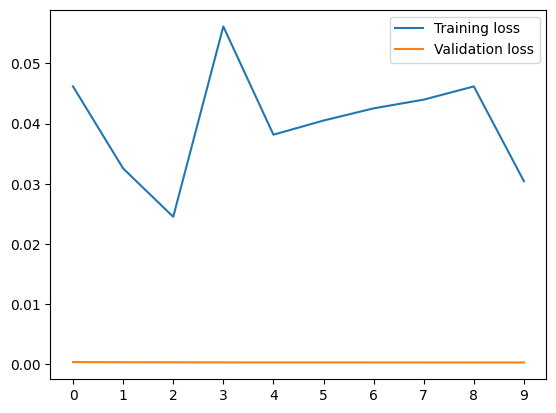

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.xticks(np.arange(0, EPOCHS, 1))
plt.show()

## Тестирование модели

### Попробуем полученную модель на test выборке

In [ ]:
predicted_ratings = np.array([])

model.eval()
with torch.no_grad():
    test_loss = 0
    for batch in test_loader:
        ratings_input = batch[1].cuda()
        outputs = model(*_input_divider(batch[0]))
        test_loss += criterion(outputs.squeeze(), ratings_input).item() * ratings_input.shape[0]
        predicted_ratings = np.concatenate((predicted_ratings, outputs.cpu().numpy().flatten()))

    test_loss /= len(test_data)
    print("Test Loss: {:.4f}".format(test_loss))

Test Loss: 0.0381


### Рассмотрим результаты в виде таблицы 

In [ ]:
test_df = pd.DataFrame({
    "user_id": [dataset[idx][0][0].item() for idx in test_data.indices],
    "movie_id": [dataset[idx][0][-1].item() for idx in test_data.indices],
    "rating": [dataset[idx][1].item() for idx in test_data.indices],
    "predicted_rating": predicted_ratings
})

inverse_columns = ["rating", "predicted_rating"]
test_df[inverse_columns] = scaler.inverse_transform(test_df[inverse_columns])
test_df.head(10)

,user_id,movie_id,rating,predicted_rating
0,8360,175370,5.0,3.905040
1,7160,22692,4.5,3.284849
2,1729,101905,5.0,4.158111
3,1422,204911,4.0,3.339553
4,19,144004,2.0,3.434561
5,247,112790,4.0,3.613738
6,61240,24937,3.0,3.799220
7,3536,188245,4.0,3.984500
8,4054,276188,1.0,3.079964
9,62644,137522,4.5,4.181160


### Реализуем функции для создания рекомендации пользователю
Вторая функция служит для представления результата в виде таблицы.

In [ ]:
def recommend_unwatched_movies(ratings: pd.DataFrame,
                               user_id: int, n: int = 5) -> list[tuple[int, float]]:

    all_movie_ids = torch.tensor(ratings.movieId.unique())
    rated_movie_ids = torch.tensor(ratings[ratings.userId == user_id].movieId.values)
    unwatched_movie_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)
    unwatched_movies = movie_genres[movie_genres.movieId.isin(unwatched_movie_ids)]
    unwatched_movies["userId"] = user_id
    user_unwatched_movies = torch.tensor(unwatched_movies.values, dtype=torch.long)
    unwatched_movie_loader = DataLoader(user_unwatched_movies, batch_size=64, shuffle=False)

    predicted_ratings = []
    with torch.no_grad():
        for batch in unwatched_movie_loader:
            outputs = model(*_input_divider(batch))
            predicted_ratings.extend(outputs.cpu().squeeze().tolist())

    movie_ratings = {}
    for i in range(len(unwatched_movie_ids)):
        movie_ratings[unwatched_movie_ids[i]] = predicted_ratings[i]

    movie_ratings_sorted = dict(sorted(movie_ratings.items(), key=lambda item: item[1], reverse=True))
    return list(movie_ratings_sorted.items())[:n]

def format_recommendations(recommendations: list[tuple[int, float]], 
                           movies_df: pd.DataFrame, scaler) -> pd.DataFrame:
                           
    rec_df = pd.DataFrame(recommendations, columns=['movieId', 'rating'])
    rec_df = pd.merge(rec_df, movies_df, on='movieId')
    rec_df[["rating"]] = scaler.inverse_transform(rec_df[["rating"]])
    return rec_df[['movieId', 'title', 'genres', 'rating']]

### Рекомендация

In [ ]:
recommendations = recommend_unwatched_movies(ratings, 150, 5)
rec_df = format_recommendations(recommendations, movies, scaler)

rec_df

,movieId,title,genres,rating
0,159817,Planet Earth (2006),Documentary,4.230767
1,170705,Band of Brothers (2001),Action|Drama|War,4.198526
2,171011,Planet Earth II (2016),Documentary,4.168451
3,174053,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller,4.081825
4,26082,Harakiri (Seppuku) (1962),Drama,4.057907


### Сохраняем модель, чтобы использовать в сервисе с API

In [ ]:
torch.save(model.state_dict(), "cfmodel.pth")

## Выводы по работе
Я считаю, что результаты проделанной работы можно считать успешными. 

На тестовой выборке невооружённым глазом видно корреляцию между реальным рейтингом и предсказанным, так что в контексте актуальной рекомендации модель справляется хорошо. Кроме того, test loss = 0.038.

В ходе тестирования функции рекомендации также можно увидеть положительный результат. Конечно, умозрительно оценить актуальность предложенного фильма из непросмотренных пользователем довольно трудно, но, как минимум, видно, что фильмы в ответе сложи между собой по тематике (Планета Земля 1 и 2 части), а также каждый из них в реальности высоко оценён большим количеством пользователей (средняя оценка на kinopoisk у предложенных пользователю фильмов ~8.5/10).

## Возможные улучшения
- [ ] Добавление данных о пользователях (пол, возраст, предпочитаемые жанры...)
- [ ] Более тщательная настройка гиперпараметров модели, количества слоёв, функций активации
- [ ] Подбор оптимальных функции потерь и оптимизатора
- [ ] Увеличение количества эпох (*может привести к переобучению!*)